<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/stock-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series forecasting: Apple stock prediction


In [12]:
!pip install yfinance --quiet

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
# getting data from Yahoo Finance
stock_name = 'AAPL'
data = yf.download(stock_name, start="2010-01-01", end="2025-04-01")

[*********************100%***********************]  1 of 1 completed


In [14]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455076,6.391278,6.422876,493729600
2010-01-05,6.451467,6.487880,6.417460,6.458087,601904800
2010-01-06,6.348844,6.477043,6.342223,6.451463,552160000
2010-01-07,6.337110,6.379844,6.291067,6.372320,477131200
2010-01-08,6.379242,6.379844,6.291369,6.328685,447610800


In [24]:
data.tail()

Price,close price
Ticker,
Date,
2025-03-25,223.750000
2025-03-26,221.529999
2025-03-27,223.850006
2025-03-28,217.899994
2025-03-31,222.130005


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-01-04 to 2025-03-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3834 non-null   float64
 1   (High, AAPL)    3834 non-null   float64
 2   (Low, AAPL)     3834 non-null   float64
 3   (Open, AAPL)    3834 non-null   float64
 4   (Volume, AAPL)  3834 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 179.7 KB


In [16]:
data['close price']=data['Close']
data.index=pd.to_datetime(data.index)


In [17]:
data.drop(columns=['Open','High','Close','Low','Volume'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-01-04 to 2025-03-31
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (close price, )  3834 non-null   float64
dtypes: float64(1)
memory usage: 59.9 KB


In [18]:
data.head()

Price,close price
Ticker,
Date,
2010-01-04,6.440331
2010-01-05,6.451467
2010-01-06,6.348844
2010-01-07,6.337110
2010-01-08,6.379242


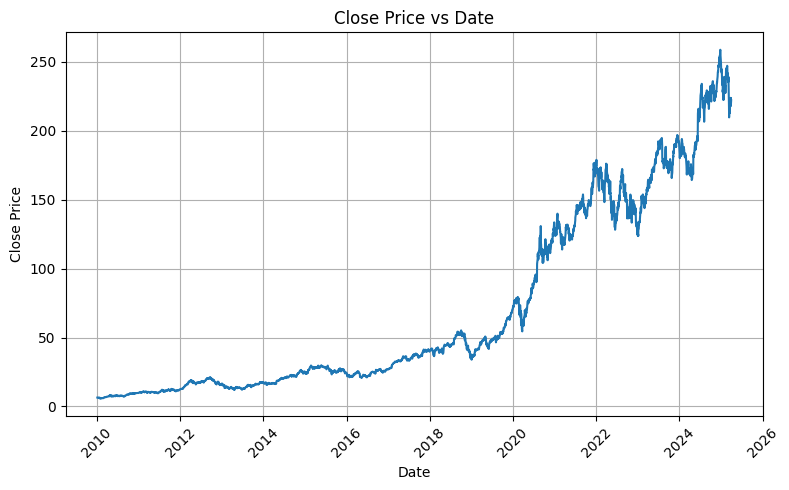

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(data.index, data['close price'])
plt.title('Close Price vs Date')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# facebook Prophet model

In [20]:
!pip install prophet --quiet

In [21]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

prophet_data=data.reset_index()
prophet_data=prophet_data.rename(columns={'Date':'ds','close price':'y'})
prophet_data.head()

Price,ds,y
Ticker,,
0,2010-01-04,6.440331
1,2010-01-05,6.451467
2,2010-01-06,6.348844
3,2010-01-07,6.337110
4,2010-01-08,6.379242


In [22]:
# 2. Train-Validation-Test Split
train_size = int(0.7 * len(prophet_data))  # 70% train
val_size = int(0.15 * len(prophet_data))   # 15% validation
train_df = prophet_data[:train_size]
val_df = prophet_data[train_size:train_size+val_size]
test_df = prophet_data[train_size+val_size:]

print(f'Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}')


Train size: 2683, Validation size: 575, Test size: 576


In [23]:
# 3. Hyperparameter Tuning (Grid Search)
changepoint_scales = [0.001, 0.01, 0.05, 0.1, 0.5]
seasonality_modes = ['additive', 'multiplicative']

best_mae = float('inf')
best_params = None

for cps in changepoint_scales:
    for mode in seasonality_modes:
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_mode=mode
        )
        model.fit(train_df)

        # Cross-validation inside training set
        df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='90 days')
        df_p = performance_metrics(df_cv)

        mae = df_p['mae'].mean()

        if mae < best_mae:
            best_mae = mae
            best_params = {'changepoint_prior_scale': cps, 'seasonality_mode': mode}

print('Best Parameters:', best_params)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/64h7yiey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/_q7soijk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6904', 'data', 'file=/tmp/tmp4piqu2qx/64h7yiey.json', 'init=/tmp/tmp4piqu2qx/_q7soijk.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model4n8wraim/prophet_model-20250428152419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2011-01-18 00:00:00 and 2020-05-30 00:00:00


  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/4qrz55xu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/yuhy9vt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74550', 'data', 'file=/tmp/tmp4piqu2qx/4qrz55xu.json', 'init=/tmp/tmp4piqu2qx/yuhy9vt1.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model_wa7bt04/prophet_model-20250428152420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


KeyError: 'trend'

In [ ]:
# 4. Train final model with best hyperparameters
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
final_model.fit(pd.concat([train_df, val_df]))  # Train on train + validation



In [ ]:
# 5. Forecast on Test Set
future = final_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = final_model.predict(future)

# Extract only forecasted part
forecast_test = forecast[-len(test_df):]

# 6. Evaluation
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2 Score: {r2:.2f}")


In [ ]:
# 7. Overfitting Check
# If training MAE is much smaller than test MAE -> overfitting
train_forecast = final_model.predict(train_df)
train_mae = mean_absolute_error(train_df['y'], train_forecast['yhat'])

print(f"Training MAE: {train_mae:.2f}")
if train_mae < 0.7 * mae:
    print("Warning: Model may be overfitting!")

# 8. Plot Actual vs Forecasted
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(test_df['ds'], y_pred, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted vs Actual Stock Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Make future dataframe (predicting for the next 90 days)
future = model.make_future_dataframe(periods=115)

# Predict the future stock prices
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Stock Price Prediction using Facebook Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Hyperparameter tuning the prophet model to get better results:

# creating lag features to be used for DNN and ensemble methods

In [ ]:
lags = [1, 7, 30, 365]  # Example: 1-day, 2-day, 5-day, 10-day lags

for lag in lags:
    data[f'Close_lag_{lag}'] = data['close price'].shift(lag)

In [ ]:
data = data.dropna()
data.head()

In [ ]:
data.tail()

In [ ]:
data['date_column']=data.index
data['day'] = data['date_column'].dt.day
data['month'] = data['date_column'].dt.month
data['year'] = data['date_column'].dt.year
data['weekday'] = data['date_column'].dt.day_name()  # Gives full weekday name (e.g., "Thursday")
#data.drop(columns=['date_column'],inplace=True)
data.head()

In [ ]:
data.tail()

In [ ]:
#Cyclic Encoding (Best for LSTMs and Time-Series)
#Best for LSTM models, as it captures the cyclic nature of time-based data.
#Transforms features into sine and cosine to preserve periodicity.
# Convert time-based features into cyclic representation
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['year_sin'] = np.sin(2 * np.pi * data['year'] / 365)
data['year_cos'] = np.cos(2 * np.pi * data['year'] / 365)
data.drop(columns=['day','month','year'],inplace=True)
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['close price',	'Close_lag_1',	'Close_lag_7',	'Close_lag_30',	'Close_lag_365',	'day_sin',	'day_cos', 'month_sin', 'month_cos',	'year_sin',	'year_cos', 'weekday']], data['close price'], test_size=0.2, shuffle=False)
print("Training Dates:", len(X_train))
print("Testing Dates:", len(X_test))
X_train.head()

A lag is a time delay or offset in a time series, representing a past value of a variable used to predict its future values.
Example:
If you're forecasting sales, a lag of 1 might mean using last month's sales to predict this month's sales.
Purpose:
Lags help capture the relationships between past and future values of a variable, which can be crucial for accurate forecasting.

ARIMA, SARIMA, and Temporal Fusion Transformer (TFT) Models:

ARIMA (Autoregressive Integrated Moving Average):
A statistical model that uses past values of a time series (autoregressive), differencing to achieve stationarity (integrated), and past forecast errors (moving average) to predict future values.
Strengths: Can handle a wide range of time series patterns, including trends and seasonality.
Limitations: Assumes linear relationships and may struggle with complex patterns.

SARIMA (Seasonal ARIMA):
An extension of ARIMA that incorporates seasonal patterns in the data.
Strengths: Captures both non-seasonal and seasonal patterns in the data.
Limitations: Still assumes linear relationships and may struggle with complex patterns.

Temporal Fusion Transformer (TFT):
A deep learning model that uses self-attention mechanisms to capture complex temporal patterns across multiple time sequences.
Strengths: Can handle complex patterns, multi-horizon forecasting, and interpretability through attention mechanisms.
Limitations: Requires a large amount of data and can be computationally expensive

# LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.fit_transform(
    X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)

X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.transform(
    X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)
X_train = pd.get_dummies(X_train, columns=['weekday'], drop_first=True)  # drop_first to avoid dummy variable trap
X_test = pd.get_dummies(X_test, columns=['weekday'], drop_first=True)

X_train.head()

In [ ]:
X_test.head()

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
X_train.shape[0]

In [ ]:
time_steps = 1
# Calculate how many complete sequences you can create
num_samples = X_train.shape[0] // time_steps
# Reshape the data accordingly
X_train_reshaped = X_train.values[:num_samples * time_steps].reshape((num_samples, time_steps, X_train.shape[1]))
print(X_train_reshaped.shape)

In [ ]:
# Ensure your test data is reshaped similarly to the training data
# Calculate the number of full sequences in the test data
num_samples_test = X_test.shape[0] // time_steps
# Reshape X_test into the same shape as X_train_reshaped
X_test_reshaped = X_test.values[:num_samples_test * time_steps].reshape((num_samples_test, time_steps, X_test.shape[1]))
# Check the new shape of X_test_reshaped
print(X_test_reshaped.shape)

In [ ]:
X_train_reshaped.dtype
# Ensure that your features (X_train_reshaped) are of numeric type
X_train_reshaped = X_train_reshaped.astype('float32')

# Ensure that your target variable (y_train) is of numeric type
y_train = y_train.astype('float32')

# Similarly, apply the same for validation data if needed
X_test_reshaped = X_test_reshaped.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),  # (time_steps, features)
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=500, batch_size=1000, validation_data=(X_test_reshaped, y_test))


In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted prices
plt.figure(figsize=(10,6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Prices")
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Prices")
plt.legend()
plt.title("Stock Price Prediction with LSTM")
plt.show()